# Physics-Informed Neural Network (PINN)
## Exponential Decay using Physics Loss Only

This notebook demonstrates how to solve the exponential decay ODE using a PINN **without training data**.

We solve:
$$ \frac{dy}{dt} = -k y $$

Instead of fitting data, the neural network minimizes the **physics residual loss**:
$$ r(t) = \frac{dy}{dt} + ky $$

The network makes random predictions initially and improves by minimizing physics violation.

## Step 1: Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cpu


## Step 2: Define the PINN Model

We use a simple fully connected neural network.
Input: time t
Output: predicted y(t)

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, t):
        return self.net(t)

model = PINN().to(device)

## Step 3: Define Physics Parameters

We define the decay constant and time domain.

In [3]:
k = 0.5

t = torch.linspace(0, 5, 200).view(-1, 1).to(device)
t.requires_grad = True

# Initial condition y(0) = 1
t0 = torch.tensor([[0.0]], device=device, requires_grad=True)
y0_true = torch.tensor([[1.0]], device=device)

## Step 4: Training using Physics Loss Only

Loss consists of:
- Physics residual loss
- Initial condition loss

No target dataset is used.

In [4]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 5000

for epoch in range(epochs):
    optimizer.zero_grad()

    y = model(t)

    dy_dt = torch.autograd.grad(
        y, t,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

    physics_loss = torch.mean((dy_dt + k * y) ** 2)

    y0_pred = model(t0)
    ic_loss = torch.mean((y0_pred - y0_true) ** 2)

    loss = physics_loss + ic_loss

    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 1.724824
Epoch 500, Loss: 0.000446
Epoch 1000, Loss: 0.000081
Epoch 1500, Loss: 0.000035
Epoch 2000, Loss: 0.000024
Epoch 2500, Loss: 0.000018
Epoch 3000, Loss: 0.000014
Epoch 3500, Loss: 0.000010
Epoch 4000, Loss: 0.000006
Epoch 4500, Loss: 0.000004


## Step 5: Compare with Analytical Solution

True solution:
$$ y(t) = e^{-kt} $$

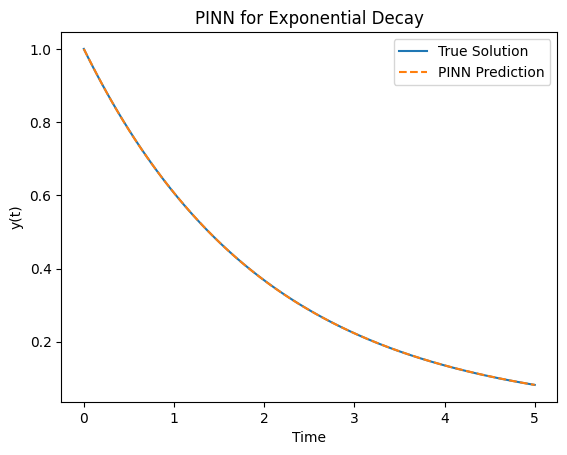

In [5]:
with torch.no_grad():
    t_test = torch.linspace(0, 5, 100).view(-1, 1).to(device)
    y_pred = model(t_test)
    y_true = torch.exp(-k * t_test)

plt.figure()
plt.plot(t_test.cpu(), y_true.cpu(), label='True Solution')
plt.plot(t_test.cpu(), y_pred.cpu(), '--', label='PINN Prediction')
plt.legend()
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('PINN for Exponential Decay')
plt.show()

## Key Takeaways

- No labeled data was used.
- The network learned the exponential function purely from physics.
- Removing the initial condition leads to infinite valid solutions.
- This demonstrates how PINNs embed physical laws into neural networks.